# Create EOPatch and fill it with L1C and derived data

Now is time to create an `EOPatch` for each out of 293 tiles of the AOI. The `EOPatch` is created by filling it with Sentinel-2 data using Sentinel Hub services. We will add the following data to each `EOPatch`:
* L1C RGB (bands B04, B03, and B02)
* SentinelHub's cloud probability map and cloud mask

Using the above information we can then also count how many times in a time series a pixel is valid or not from the cloud mask.

---

An `EOPatch` is created and manipulated using `EOTasks` chained in an `EOWorkflow`. In this studio the final workflow is a sequence of the following tasks:
1. Create `EOPatch` by filling it with RGB L1C data, together with cloud masks and cloud probabilities from Sentinel-Hub (s2cloudless)
2. Validate pixels using the cloud mask
3. Count number of valid observations per pixel using valid data mask
4. Export valid pixel count to tiff file
5. Save EOPatch to disk

In [ ]:
!pip install aenum

In [ ]:
!pip install sentinelhub

In [ ]:
!pip install eo-learn.core

  Using cached eo_learn_core-1.5.0-py3-none-any.whl (3.1 kB)


In [ ]:
!pip install eo-learn

In [ ]:
!pip install eo-learn.io

In [ ]:
!pip install eo-learn.mask

In [ ]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import itertools

# Built-in modules
import os

# Basics of Python data handling and visualization
import numpy as np
from aenum import MultiValueEnum

np.random.seed(42)
import geopandas as gpd
import joblib

# Machine learning
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import Polygon
from sklearn import metrics, preprocessing
from tqdm.auto import tqdm

from sentinelhub import DataCollection, UtmZoneSplitter

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
    EONode,
    OutputTask,
)
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.features.extra.interpolation import LinearInterpolationTask
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask

/usr/local/lib/python3.10/dist-packages/eolearn/__init__.py:12: UserWarning: You are currently using an outdated installation of `eo-learn` for submodules ['core', 'io', 'mask']. You can find instructions on how to install `eo-learn` correctly at https://github.com/sentinel-hub/eo-learn/issues/733.
  warnings.warn(


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
import logging

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

In [ ]:
import pickle

In [ ]:
import os

In [ ]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(".",  "example_data")
# Locations for save the splitter to pickle file for later use
TILE_FOLDER = os.path.join(".", "tile-def")
# Locations for save the figs
FIGS_FOLDER = os.path.join(".", "figs")
# Locations for save epopatches
EOPATCH_FOLDER = os.path.join(".", "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(".", "eopatches_sampled")
# Locations for result
RESULTS_FOLDER = os.path.join(".", "results")
# Location valid_count
VALID_FOLDER = os.path.join(".", "valid_count-L1C")
for folder in (DATA_FOLDER, TILE_FOLDER, EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, FIGS_FOLDER, VALID_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

LogIn SentinelHub register

In [ ]:
from sentinelhub import SHConfig

config = SHConfig()

config

SHConfig(
  instance_id='',
  sh_client_id='********************************e4bf',
  sh_client_secret='************************************4znB',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/oauth/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

In [ ]:
# Insert your credentials here in case you don't already have them in the config.toml file:
# Auth CLient Imbabura-eo-learn
SH_CLIENT_ID = "01a8d1de-a7e3-44d0-a12c-166d0e1de4bf"
SH_CLIENT_SECRET = "u9Fz2MOfiVsb5vzzgUQUVbt7iY5PlaHFF8yc4znB"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

config = SHConfig()

if SH_CLIENT_ID and SH_CLIENT_SECRET:
    config.sh_client_id = SH_CLIENT_ID
    config.sh_client_secret = SH_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Sentinel Hub BYOC API, please provide the credentials (client ID and client secret).")

if AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY:
    config.aws_access_key_id = AWS_ACCESS_KEY_ID
    config.aws_secret_access_key = AWS_SECRET_ACCESS_KEY

# If you want to save the instance, deactivate
config.save("default-profile")
config

SHConfig(
  instance_id='',
  sh_client_id='********************************e4bf',
  sh_client_secret='************************************4znB',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/oauth/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

### Get BBoxSplitter with tile definitions

In [ ]:
# Load input files
from google.colab import files
uploaded = files.upload()

In [ ]:
with open(os.path.join(TILE_FOLDER,"Imbabura_buffered_bbox_32617_17x25.pickle"), "rb") as fp:
    bbox_splitter = pickle.load(fp)

In [ ]:
patch_ids=len(bbox_splitter.bbox_list)
patch_ids

195

In [ ]:
id_patch=110
bbox_splitter.bbox_list[id_patch]

BBox(((796644.1505816347, 38235.17647058824), (803171.883850342, 43148.41176470588)), crs=CRS('32617'))

In [ ]:
bbox_splitter.info_list[id_patch]

{'parent_bbox': BBox(((692200.4182823192, 13669.0), (855393.7499999998, 97194.0)), crs=CRS('32617')),
 'index_x': 16,
 'index_y': 5}

### Define what makes a pixel valid

In [ ]:
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

In [ ]:
import pandas as pd
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
#idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

common_crs = bbox_splitter.bbox_list[0].crs
df = pd.DataFrame({"index_x": idxs_x, "index_y": idxs_y})
bbox_gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)

In [ ]:
# select a 5x5 area (id of center patch)
ID = 110

# Obtain surrounding 5x5 patches
patch_ids = []
for idx, info in enumerate(info_list):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= 2 and abs(info["index_y"] - info_list[ID]["index_y"]) <= 2:
        patch_ids.append(idx)

# Check if final size is 5x5
if len(patch_ids) != 5 * 5:
    print("Warning! Use a different central patch ID, this one is on the border.")

# Change the order of the patches (useful for plotting)
patch_ids = np.transpose(np.fliplr(np.array(patch_ids).reshape(5, 5))).ravel()

# Save to shapefile
shapefile_name = "grid_imbabura_5km.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

# eo-learn Workflow to create patches

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch:

L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.

SentinelHub's cloud mask

1.   Additionally, we will add:
2.   Calculated NDVI, NDWI, and NDBI information


A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:

*   IS_DATA == True
*   CLOUD_MASK == 0 (1 indicates cloudy pixels and 255 indicates NO_DATA)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

### Define custom tasks

In [ ]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

## Initialise tasks

In [ ]:
# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)


# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)
ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)
ndbi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
)


# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

Reference map task
For this example, a subset of the country-wide reference for land-use-land-cover is provided. It is available in the form of a geopackage, which contains polygons and their corresponding labels. The labels represent the following 10 classes:

*   lulcid = 0, name = no data
*   lulcid = 1, name = cultivated land
*   lulcid = 2, name = forest
*   lulcid = 3, name = grassland
*   lulcid = 4, name = shrubland
*   lulcid = 5, name = water
*   lulcid = 6, name = wetlands
*   lulcid = 7, name = tundra
*   lulcid = 8, name = artificial surface
*   lulcid = 9, name = bareland
*   lulcid = 10, name = snow and ice

We have defined a land cover enum class for ease of use below.

In [ ]:
class LULC(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_DATA = "No Data", 0, "#ffffff"
    CULTIVATED_LAND = "Cultivated Land", 1, "#ffff00"
    FOREST = "Forest", 2, "#054907"
    GRASSLAND = "Grassland", 3, "#ffa500"
    SHRUBLAND = "Shrubland", 4, "#806000"
    WATER = "Water", 5, "#069af3"
    WETLAND = "Wetlands", 6, "#95d0fc"
    TUNDRA = "Tundra", 7, "#967bb6"
    ARTIFICIAL_SURFACE = "Artificial Surface", 8, "#dc143c"
    BARELAND = "Bareland", 9, "#a6a6a6"
    SNOW_AND_ICE = "Snow and Ice", 10, "#000000"

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm([x - 0.5 for x in range(len(LULC) + 1)], lulc_cmap.N)

The main point of this task is to create a raster mask from the vector polygons and add it to the eopatch. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task `VectorToRaster` from the `eolearn.geometry` package. All polygons belonging to the each of the classes are separately burned to the raster mask.

Land use data are public in Imbabura, you can use the provided partial dataset for this example, or download the full dataset (if you want to upscale the project) [from our bucket](http://eo-learn.sentinel-hub.com/). The datasets have already been pre-processed for the purposes of the example.

In [ ]:
land_use_ref_path = os.path.join(DATA_FOLDER, "Imbabura_17n18n2022010120221231lulc_class_reference.gpkg")

In [ ]:
vector_feature = FeatureType.VECTOR_TIMELESS, "LULC_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, land_use_ref_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "LULC"),
    values_column="lulcid",
    raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_dtype=np.uint8,
)

## Define workflow

All the tasks that were defined so far create and fill the EOPatches. The tasks need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an EOWorkflow which does this for you.

The following workflow is created and executed:

Create EOPatches with band and cloud data
Calculate and add NDVI, NDWI, NORM
Add mask of valid pixels
Add scalar feature representing the count of valid pixels
Save eopatches
An EOWorkflow can be linear or more complex, but it should be acyclic. Here we will use the linear case of the EOWorkflow, available as LinearWorkflow

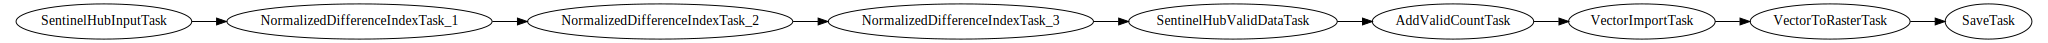

In [ ]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data, ndvi, ndwi, ndbi, add_sh_validmask, add_valid_count, vector_import_task, rasterization_task, save
)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

In [ ]:
%%time

# Time interval for the SH request
time_interval = ["2022-01-01", "2022-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patch_ids]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

DEBUG:eolearn.core.eoworkflow:Computing SentinelHubInputTask(*[], **{'bbox': BBox(((783588.6840442204, 48061.647058823524), (790116.4173129275, 52974.882352941175)), crs=CRS('32617')), 'time_interval': ['2020-01-01', '2020-12-31']})
DEBUG:eolearn.core.eoworkflow:Computing SentinelHubInputTask(*[], **{'bbox': BBox(((803171.883850342, 48061.647058823524), (809699.6171190492, 52974.882352941175)), crs=CRS('32617')), 'time_interval': ['2020-01-01', '2020-12-31']})
DEBUG:eolearn.core.eoworkflow:Computing SentinelHubInputTask(*[], **{'bbox': BBox(((790116.4173129275, 48061.647058823524), (796644.1505816347, 52974.882352941175)), crs=CRS('32617')), 'time_interval': ['2020-01-01', '2020-12-31']})


  0%|          | 0/25 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
DEBUG:fiona.ogrext:Next index: 45543
DEBUG:fiona.ogrext:Next index: 45544
DEBUG:fiona.ogrext:Next index: 45545
DEBUG:fiona.ogrext:Next index: 45546
DEBUG:fiona.ogrext:Next index: 45547
DEBUG:fiona.ogrext:Next index: 45548
DEBUG:fiona.ogrext:Next index: 45549
DEBUG:fiona.ogrext:Next index: 45550
DEBUG:fiona.ogrext:Next index: 45551
DEBUG:fiona.ogrext:Next index: 45552
DEBUG:fiona.ogrext:Next index: 45553
DEBUG:fiona.ogrext:Next index: 45554
DEBUG:fiona.ogrext:Next index: 45555
DEBUG:fiona.ogrext:Next index: 45556
DEBUG:fiona.ogrext:Next index: 45557
DEBUG:fiona.ogrext:Next index: 45558
DEBUG:fiona.ogrext:Next index: 45559
DEBUG:fiona.ogrext:Next index: 45560
DEBUG:fiona.ogrext:Next index: 45561
DEBUG:fiona.ogrext:Next index: 45562
DEBUG:fiona.ogrext:Next index: 45563
DEBUG:fiona.ogrext:Next index: 45564
DEBUG:fiona.ogrext:Next index: 45565
DEBUG:fiona.ogrext:Next index: 45566
DEBUG:fiona.ogrext:Next index: 45567
DEBUG:fiona.og

CPU times: user 2min 24s, sys: 18.4 s, total: 2min 42s
Wall time: 25min 25s


#### Check the content of the EOPatch

In [ ]:
eopatch=EOPatch.load('./eopatches/eopatch_0/')

In [ ]:
patch = eopatch
eopatch

EOPatch(
  bbox=BBox(((783588.6840442204, 48061.647058823524), (790116.4173129275, 52974.882352941175)), crs=CRS('32617'))
  timestamps=[2020-01-07 15:43:02, ...]<length=40>
  vector_timeless={
    LULC_REFERENCE: geopandas.GeoDataFrame(columns=['RABA_PID', 'RABA_ID', 'VIR', 'AREA', 'STATUS', 'D_OD', 'lulcid', 'lulcname', 'geometry'], length=0, crs=EPSG:32617)
  }
  mask={
    CLM: numpy.ndarray(shape=(40, 491, 653, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(40, 491, 653, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(40, 491, 653, 1), dtype=bool)
  }
  data={
    BANDS: numpy.ndarray(shape=(40, 491, 653, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(40, 491, 653, 1), dtype=uint8)
    NDBI: numpy.ndarray(shape=(40, 491, 653, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(40, 491, 653, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(40, 491, 653, 1), dtype=float32)
  }
  mask_timeless={
    LULC: numpy.ndarray(shape=(491, 653, 1), dtype=uint8)
    VALID_COUNT: numpy.

In [ ]:
patch.timestamp

<ipython-input-41-627632d339b5>:1: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  patch.timestamp


[datetime.datetime(2020, 1, 7, 15, 43, 2),
 datetime.datetime(2020, 1, 12, 15, 43, 2),
 datetime.datetime(2020, 1, 17, 15, 43, 1),
 datetime.datetime(2020, 1, 22, 15, 43, 1),
 datetime.datetime(2020, 2, 6, 15, 43, 1),
 datetime.datetime(2020, 2, 11, 15, 43),
 datetime.datetime(2020, 2, 16, 15, 43, 3),
 datetime.datetime(2020, 3, 12, 15, 43, 4),
 datetime.datetime(2020, 3, 22, 15, 43, 4),
 datetime.datetime(2020, 4, 21, 15, 43, 8),
 datetime.datetime(2020, 4, 26, 15, 43, 2),
 datetime.datetime(2020, 5, 1, 15, 43, 11),
 datetime.datetime(2020, 5, 6, 15, 43, 5),
 datetime.datetime(2020, 5, 11, 15, 43, 12),
 datetime.datetime(2020, 5, 16, 15, 43, 7),
 datetime.datetime(2020, 5, 21, 15, 43, 13),
 datetime.datetime(2020, 5, 26, 15, 43, 8),
 datetime.datetime(2020, 5, 31, 15, 43, 14),
 datetime.datetime(2020, 7, 5, 15, 43, 9),
 datetime.datetime(2020, 7, 15, 15, 43, 9),
 datetime.datetime(2020, 7, 25, 15, 43, 10),
 datetime.datetime(2020, 7, 30, 15, 43, 13),
 datetime.datetime(2020, 8, 4, 15,

Due to the maxcc filtering, not all patches have the same amount of timestamps.

Let's select a date and draw the closest timestamp for each eopatch.

In [ ]:
# Draw the RGB images
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

date = datetime.datetime(2020, 7, 1)

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    dates = np.array([timestamp.replace(tzinfo=None) for timestamp in eopatch.timestamps])
    closest_date_id = np.argsort(abs(date - dates))[0]

    ax = axs[i // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["BANDS"][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

Output hidden; open in https://colab.research.google.com to view.

## Visualize the reference map

  0%|          | 0/25 [00:00<?, ?it/s]

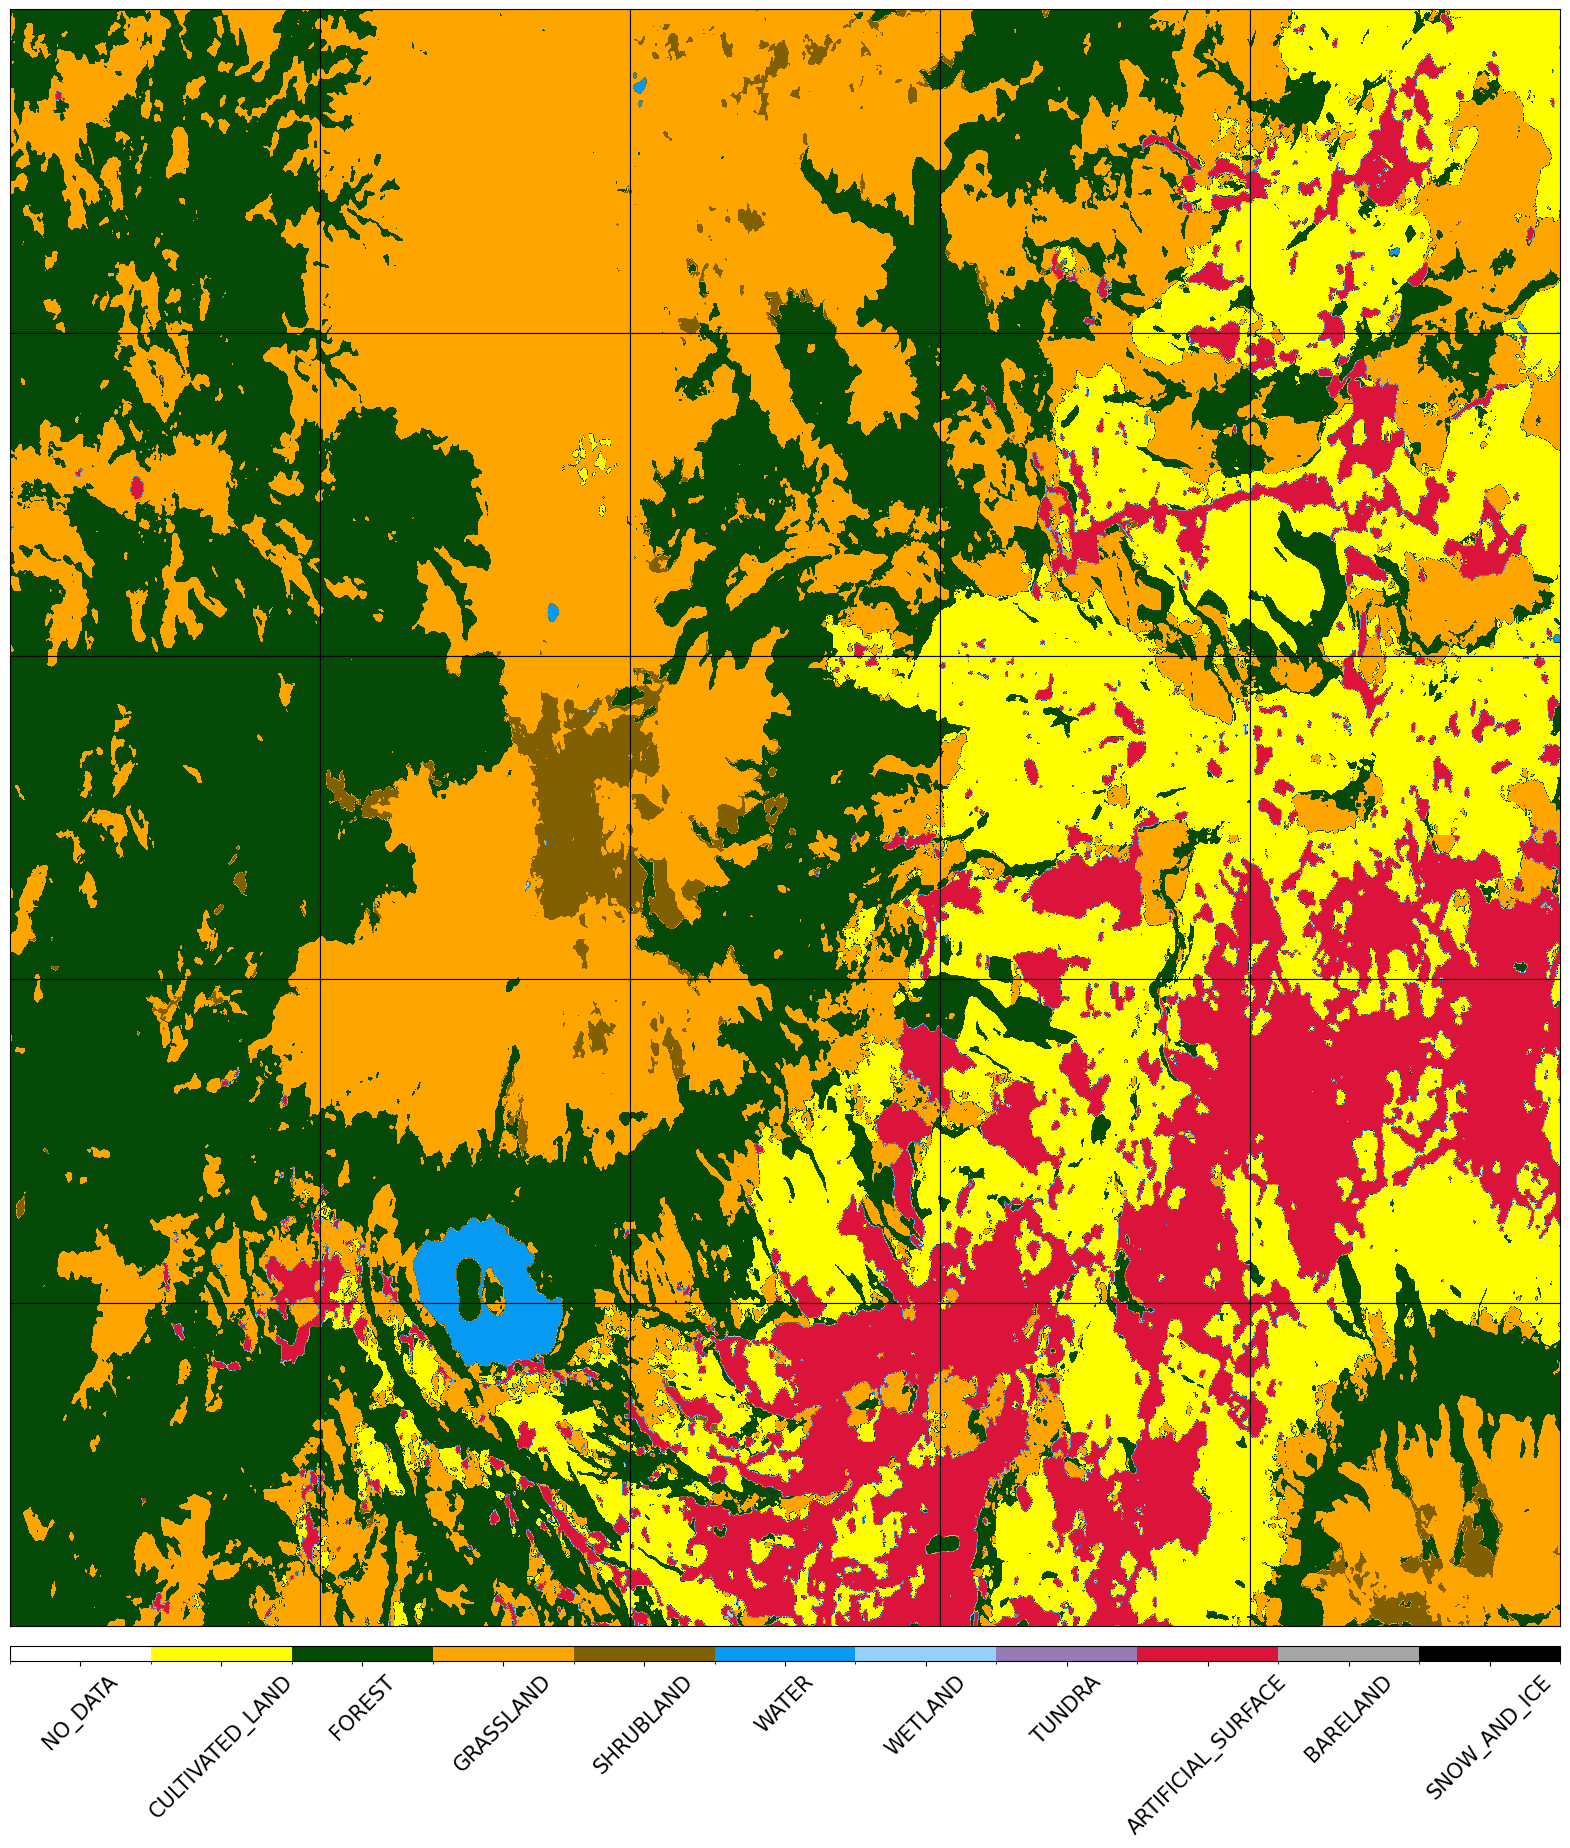

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["LULC"].squeeze(), cmap=lulc_cmap, norm=lulc_norm)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show();

name_file_fig = os.path.join(FIGS_FOLDER, f"Imbabura-LULC-before-training.png")
fig.savefig(name_file_fig, bbox_inches="tight")

#### Plot RGB, SCL, and Cloud probability, and number of valid observations

In [ ]:
def plot_frame(patch, idx, scale=1, save_fig=True):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

    axs[0, 0].imshow(scale * patch.data["NDVI"][idx])
    axs[0, 0].set_title(f"RGB {patch.timestamp[idx]}")
    axs[0, 1].imshow(patch.mask["IS_VALID"][idx, ..., 0], vmin=0, vmax=1)
    axs[0, 1].set_title(f"Valid data {patch.timestamp[idx]}")
    axs[1, 0].imshow(patch.mask["CLM"][idx, ..., 0], vmin=0, vmax=1)
    axs[1, 0].set_title(f"SentinelHub Cloud Mask {patch.timestamp[idx]}")
    divider = make_axes_locatable(axs[1, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = axs[1, 1].imshow(patch.data["CLP"][idx, ..., 0] / 255.0, cmap=plt.cm.inferno, vmin=0.0, vmax=1.0)
    fig.colorbar(im, cax=cax, orientation="vertical")
    axs[1, 1].imshow(patch.data["NDWI"][idx, ..., 0] / 255.0, cmap=plt.cm.inferno)
    axs[1, 1].set_title(f"SentinelHub Cloud Probability {patch.timestamp[idx]}")

    if save_fig:
        fig.savefig(f"figs/patch_{idx}_{patch.timestamp[idx]}.png", bbox_inches="tight")
        fig.clf()

In [ ]:
plot_frame(patch, 0, scale=3.5)

<ipython-input-100-2195270206a4>:5: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[0, 0].set_title(f"RGB {patch.timestamp[idx]}")
<ipython-input-100-2195270206a4>:7: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[0, 1].set_title(f"Valid data {patch.timestamp[idx]}")
<ipython-input-100-2195270206a4>:9: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[1, 0].set_title(f"SentinelHub Cloud Mask {patch.timestamp[idx]}")
<ipython-input-100-2195270206a4>:15: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[1, 1].set_title(f"SentinelHub Cloud Probability {patch.timestamp[idx]}")
<ipython-input-100-2195270206a4>:18: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  fig.savefig(f"figs/patch_{idx}_{patch.timestamp[idx]}.png", bbox_inches="tight")


<Figure size 2000x2000 with 0 Axes>

<ipython-input-42-612aa46fea2d>:5: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[0, 0].set_title(f"RGB {patch.timestamp[idx]}")
<ipython-input-42-612aa46fea2d>:7: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[0, 1].set_title(f"Valid data {patch.timestamp[idx]}")
<ipython-input-42-612aa46fea2d>:9: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[1, 0].set_title(f"SentinelHub Cloud Mask {patch.timestamp[idx]}")
<ipython-input-42-612aa46fea2d>:15: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  axs[1, 1].set_title(f"SentinelHub Cloud Probability {patch.timestamp[idx]}")


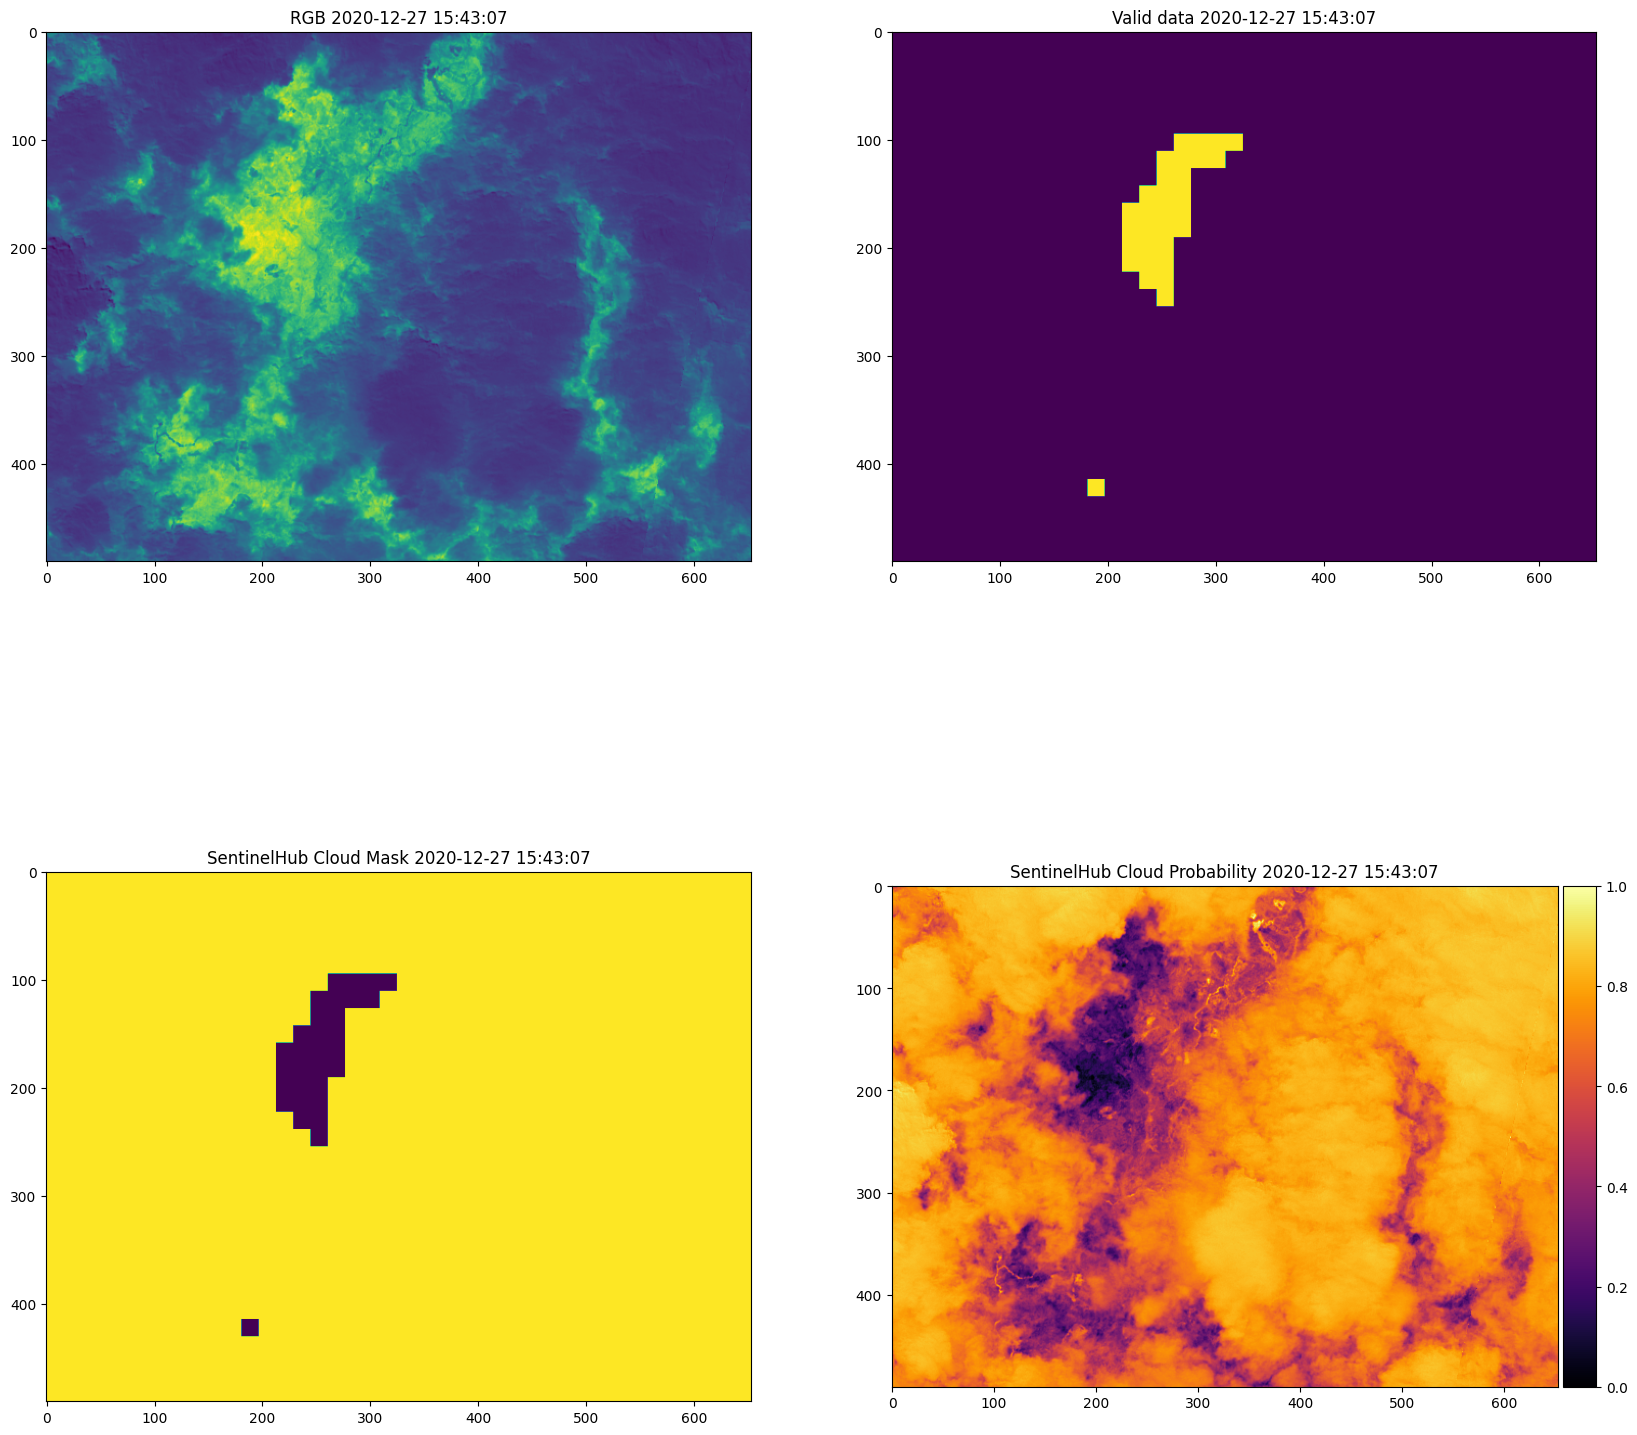

In [ ]:
plot_frame(patch, -1)

#### Plot number of valid observations

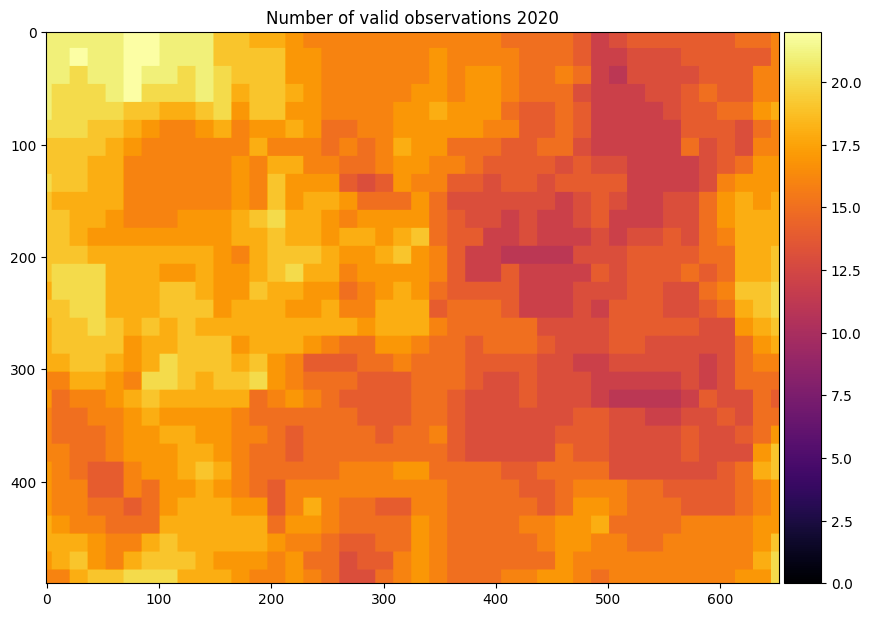

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(
    patch.mask_timeless["VALID_COUNT"][..., 0],
    cmap=plt.cm.inferno,
    vmin=0,
    vmax=np.max(patch.mask_timeless["VALID_COUNT"]),
)
ax.set_title("Number of valid observations 2020")
fig.colorbar(im, cax=cax, orientation="vertical")
fig.savefig("figs/number_of_valid_observations_eopatch_0.png", bbox_inches="tight")

#### Plot average cloud probability

In [ ]:
avecld = np.sum(patch.data["CLP"][..., 0], axis=(0)) / patch.data["CLP"].shape[0]
avecld /= 255.0

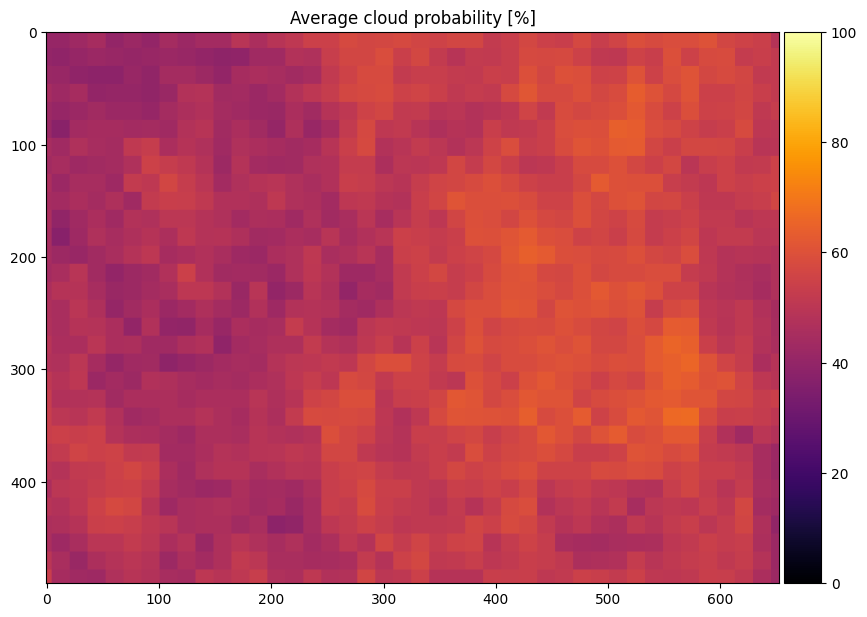

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(avecld * 100, cmap=plt.cm.inferno, vmin=0, vmax=100.0)
ax.set_title("Average cloud probability [%]")
fig.colorbar(im, cax=cax, orientation="vertical");

fig.savefig("figs/average_cloud_probability_eopatch_0.png", bbox_inches="tight")

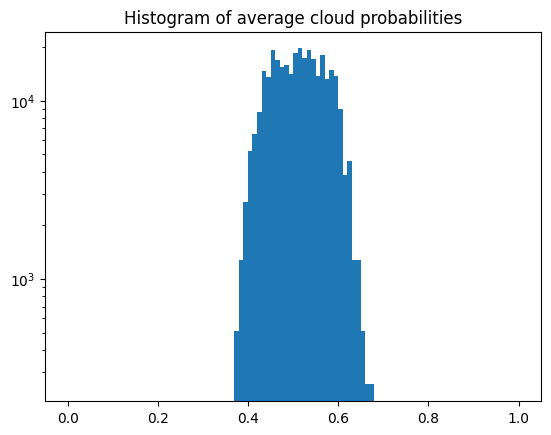

In [ ]:
plt.hist((avecld).flatten(), range=(0, 1), bins=100, log=True)
plt.title("Histogram of average cloud probabilities");

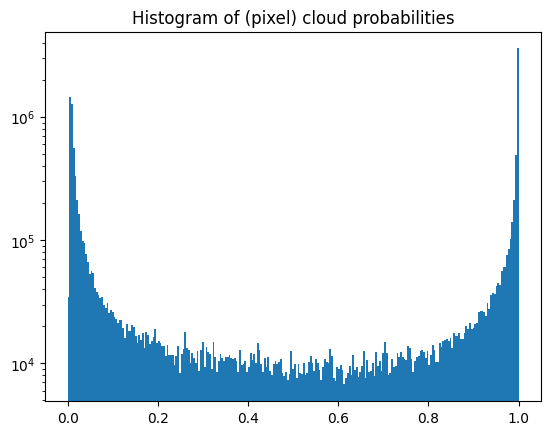

In [ ]:
plt.hist((patch.data["CLP"]).flatten() / 255.0, range=(0, 1), bins=255, log=True)
plt.title("Histogram of (pixel) cloud probabilities");

#### Plot fraction of valid pixels per frame

In [ ]:
def valid_fraction(arr):
    """
    Calculates fraction of non-zero pixels.
    """
    return np.count_nonzero(arr) / np.size(arr)

In [ ]:
valid_frac = np.apply_along_axis(
    valid_fraction, axis=1, arr=np.reshape(patch.mask["IS_VALID"], (patch.mask["IS_VALID"].shape[0], -1))
)

In [ ]:
valid_frac.shape

(40,)

<ipython-input-53-c2c24c8179ee>:2: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  ax.plot(patch.timestamp, valid_frac, "o-")


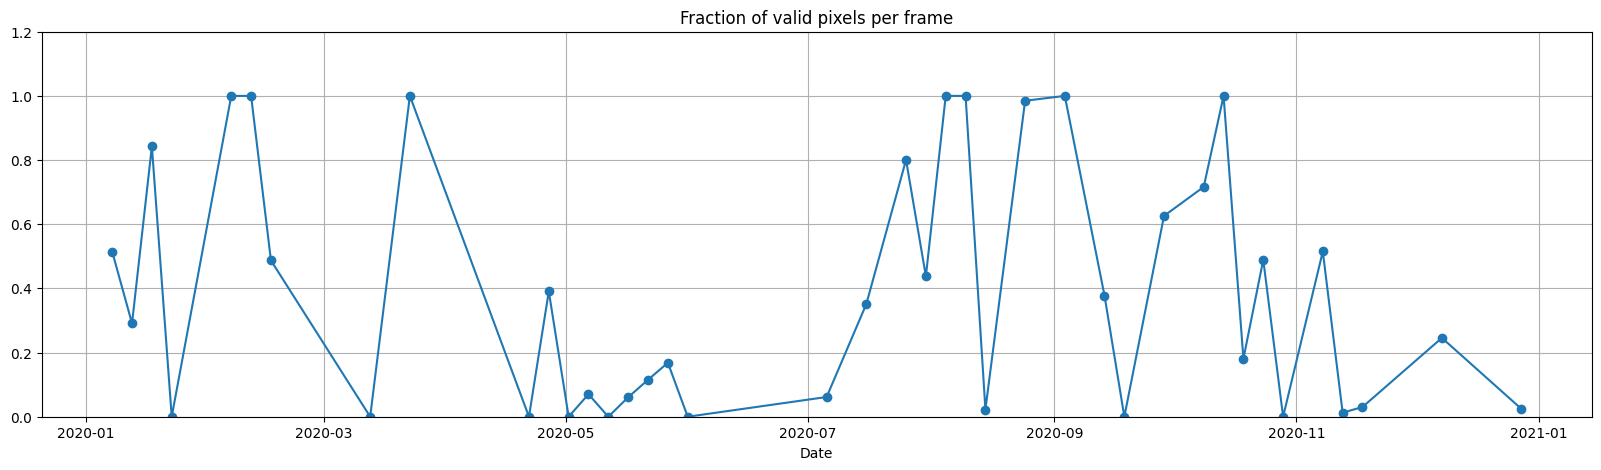

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(patch.timestamp, valid_frac, "o-")
ax.set_title("Fraction of valid pixels per frame")
ax.set_xlabel("Date")
ax.set_ylim(0.0, 1.2)
ax.grid()
fig.savefig("figs/fraction_valid_pixels_per_frame_eopatch-0.png", bbox_inches="tight")

## Remove too cloudy frames

After inspection of the individual frames in the time series it gets clear that some frames are useless for further analysis -- covered almost completely with clouds. Let's remove frames with 60% or less valid pixels.

For this purpose we will define a new workflow which will:
1. Read EOPatch from disk
2. Remove frames with fraction of valid pixels below 60%

In the real world example the last two tasks would be part of the original workflow defined above.

### Define and initalise tasks

In [ ]:
class AddValidDataFraction(EOTask):
    def execute(self, eopatch):
        vld = eopatch.get_feature(FeatureType.MASK, "IS_VALID")
        frac = np.apply_along_axis(valid_fraction, axis=1, arr=np.reshape(vld, (vld.shape[0], -1)))

        eopatch.add_feature(FeatureType.SCALAR, "VALID_FRAC", frac[:, np.newaxis])
        return eopatch

In [ ]:
class ValidDataFractionPredicate:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = array[..., 0]
        return coverage > self.threshold

In [ ]:
load_task = LoadTask(path=EOPATCH_FOLDER)
add_coverage = AddValidDataFraction(load_task )
remove_cloudy_scenes = SimpleFilterTask((FeatureType.SCALAR, "VALID_FRAC"), ValidDataFractionPredicate(0.6))

# add EOnode
# Each EONode object defines dependecies to other EONode objects:
load_node = EONode(load_task, inputs=[], name="Load EOPatch")

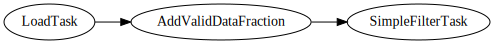

In [ ]:
#clean_up_work = LinearWorkflow(load, add_coverage, remove_cloudy_scenes)
workflow_clean_nodes = linearly_connect_tasks(load_task, add_coverage, remove_cloudy_scenes)
clean_up_work = EOWorkflow(workflow_clean_nodes)

# Let's visualize it
clean_up_work.dependency_graph()

In [ ]:
eopatch = patch
eopatch

EOPatch(
  bbox=BBox(((783588.6840442204, 48061.647058823524), (790116.4173129275, 52974.882352941175)), crs=CRS('32617'))
  timestamps=[2020-01-07 15:43:02, ...]<length=40>
  vector_timeless={
    LULC_REFERENCE: geopandas.GeoDataFrame(columns=['RABA_PID', 'RABA_ID', 'VIR', 'AREA', 'STATUS', 'D_OD', 'lulcid', 'lulcname', 'geometry'], length=0, crs=EPSG:32617)
  }
  mask={
    CLM: numpy.ndarray(shape=(40, 491, 653, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(40, 491, 653, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(40, 491, 653, 1), dtype=bool)
  }
  data={
    BANDS: numpy.ndarray(shape=(40, 491, 653, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(40, 491, 653, 1), dtype=uint8)
    NDBI: numpy.ndarray(shape=(40, 491, 653, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(40, 491, 653, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(40, 491, 653, 1), dtype=float32)
  }
  mask_timeless={
    LULC: numpy.ndarray(shape=(491, 653, 1), dtype=uint8)
    VALID_COUNT: numpy.

In [ ]:
idx = 0
eopatch = patch
cleaned_up_results = clean_up_work.execute({load_node: {"eopatch_folder": f"eopatch_{idx}"}})

cleaned_up_results

In [ ]:
cleaned_patch = list(cleaned_up_results.values())[-1]

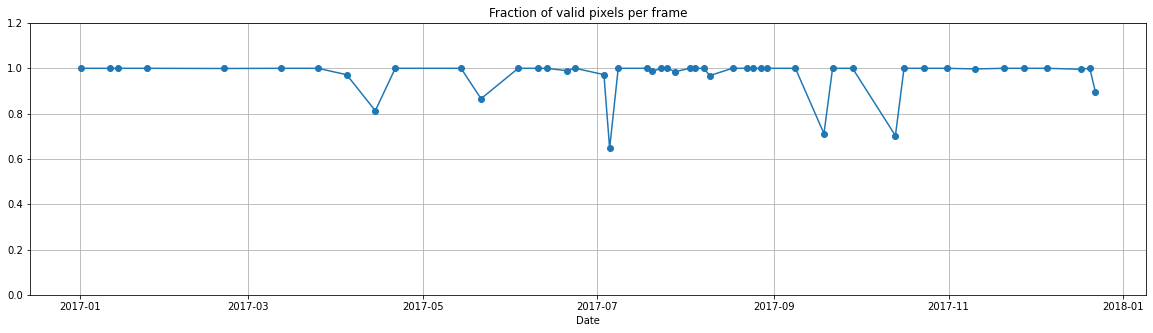

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(cleaned_patch.timestamp, cleaned_patch.scalar["VALID_FRAC"][..., 0], "o-")
ax.set_title("Fraction of valid pixels per frame")
ax.set_xlabel("Date")
ax.set_ylim(0.0, 1.2)
ax.grid()
fig.savefig("figs/fraction_valid_pixels_per_frame_cleaned-eopatch-0.png", bbox_inches="tight")

Number of valid frames

In [ ]:
print(len(cleaned_patch.timestamp))

49


## Putting everything together

Create a single workflow with all tasks.

In [ ]:
# 1. Create `EOPatch` by filling it with RGB L1C data
input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    resolution=(10, 10),
    bands=[],
    additional_data=[(FeatureType.MASK, "dataMask"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    maxcc=0.8,
)

# 2. Validate pixels using SentinelHub's cloud detection mask
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), "VALID_DATA_SH")


# 3. Calculate fraction of valid pixels
add_coverage = AddValidDataFraction()

# 4. Remove frames with fraction of valid pixels below 60%
remove_cloudy_scenes = SimpleFilterTask((FeatureType.SCALAR, "VALID_FRAC"), ValidDataFractionPredicate(0.6))


# 5. Count number of valid observations per pixel using valid data mask
count_val_sh = CountValid("VALID_DATA_SH", "VALID_COUNT_SH")

# 6. Export valid pixel count to tiff file
export_val_sh = ExportToTiffTask((FeatureType.MASK_TIMELESS, "VALID_COUNT_SH"))

# 7. Save EOPatch to disk
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [ ]:
# Define the workflow
workflow_final_nodes = linearly_connect_tasks(input_task, add_sh_valmask, add_coverage, remove_cloudy_scenes, count_val_sh, export_val_sh, save)
final_workflow = EOWorkflow(workflow_final_nodes)

# Let's visualize it
final_workflow.dependency_graph()

In [ ]:
def execute_workflow(tile_idx):
    bbox = bbox_splitter.bbox_list[tile_idx]
    info = bbox_splitter.info_list[tile_idx]
    tiff_name = f'val_count_sh_cleaned_eopatch_{tile_idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'
    patch_name = f'eopatch_{tile_idx}_row-{info["index_x"]}_col-{info["index_y"]}'
    results = final_workflow.execute(
        {
            input_task: {"bbox": bbox, "time_interval": time_interval},
            export_val_sh: {"filename":  os.path.join(VALID_FOLDER, "valid_count-L1C", tiff_name)},
            save: {"eopatch_folder": patch_name},
        }
    )
    del results

In [ ]:
time_interval = ["2022-01-01", "2022-12-31"]

In [ ]:
execute_workflow(0)

Next step would be to run the workflow over all 293 tiles.